In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mydata/X_train_padding.npy
/kaggle/input/mydata/y_train_padding.npy


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [23]:
class oneDCNN(nn.Module):
    def __init__(self):
        super(oneDCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 14)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, seq_len, num_features) to (batch_size, num_features, seq_len)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.permute(0, 2, 1)  # Change back to (batch_size, seq_len, num_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
# Load data
X = np.load('/kaggle/input/mydata/X_train_padding.npy')
Y = np.load('/kaggle/input/mydata/y_train_padding.npy')

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Create a TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [25]:
# Initialize the model, loss function, and optimizer
model = oneDCNN()
if torch.cuda.is_available():
    model = model.to('cuda')
criterion = nn.MSELoss()  # Assuming a regression problem
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [26]:
num_epochs = 10
all_losses = []

Epoch [1/10], Avg. Loss: 1665.6987
Epoch [2/10], Avg. Loss: 881.1135
Epoch [3/10], Avg. Loss: 692.0984
Epoch [4/10], Avg. Loss: 686.3978
Epoch [5/10], Avg. Loss: 687.1522
Epoch [6/10], Avg. Loss: 683.9028
Epoch [7/10], Avg. Loss: 683.7190
Epoch [8/10], Avg. Loss: 685.5368
Epoch [9/10], Avg. Loss: 684.2093
Epoch [10/10], Avg. Loss: 691.2685


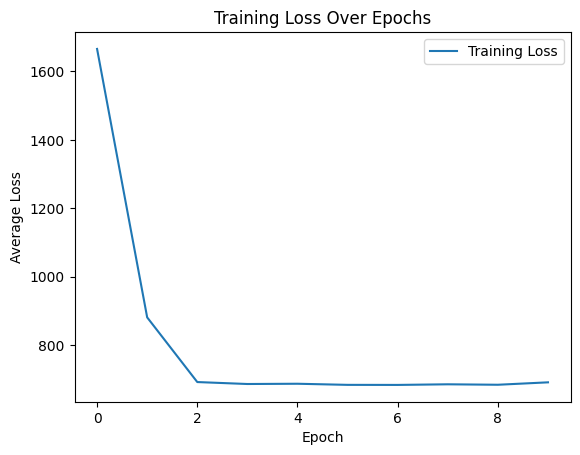

In [27]:
for epoch in range(num_epochs):
    epoch_loss = 0.0

    for batch_data, batch_target in dataloader:
        if torch.cuda.is_available():
            batch_data, batch_target = batch_data.to('cuda'), batch_target.to('cuda')
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_target)  # Ensure target shape matches output shape
        loss.backward()
        optimizer.step()

        # Accumulate the loss for the current batch
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    avg_epoch_loss = epoch_loss / len(dataloader)

    # Print the average loss for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Avg. Loss: {avg_epoch_loss:.4f}')

    # Save the average loss for plotting
    all_losses.append(avg_epoch_loss)

# Plot the training loss
plt.plot(all_losses, label='Training Loss')
plt.savefig('CNN_training_loss.png')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()